<a id="section_CART"></a> 
## Workshop Final DS Digital House

<h1 style='background:#3f4788; border:2; font-size:300%; font-weight: bold;
color:white; padding:20px'><center>Análise de Conjunto de Dados de Credit Score</center></h1>

<center><img src = "https://storage.googleapis.com/kaggle-datasets-images/2289007/3846912/ad5e128929f5ac26133b67a6110de7c0/dataset-cover.jpg?t=2022-06-22-14-33-45" width = 900 height = 400/></center>


Você está trabalhando como cientista de dados em uma empresa financeira global. Ao longo dos anos, a empresa coletou dados bancários básicos e reuniu muitas informações relacionadas a crédito de alguns clientes. A gerência quer construir um sistema inteligente para segregar as pessoas em faixas de pontuação de crédito para reduzir os esforços manuais e melhorar a precisão das apurações.

Tarefa
Dadas as informações relacionadas ao crédito de uma pessoa, construa um modelo de aprendizado de máquina que possa classificar a pontuação de crédito.


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">

<h1 style='background:#3f4788; border:0; border-radius: 10px; color:white;padding:20px'><center> Sumário </center></h1>

### [**1. Importando bibliotecas e carregando dados**](#title-one)

### [**2. Data Wrangling, EDA e Visualizações**](#title-two)

### [**3. Limpeza de dados**](#title-three)

### [**4. Pré-processamento de Dados**](#title-four)

### [**5. Feature Importance e Feature Selection**](#title-five)

### [**6. Modelagem**](#title-six)

<a id="title-one"></a>
<h1 style='background:#3f4788; border:2; border-radius: 10px; color:white;padding:20px'><center>Importando bibliotecas e carregando dados</center></h1>

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
pd.set_option('display.max_columns', None)
import missingno as msno
#from dataprep.eda import plot, plot_correlation, create_report, plot_missing

%matplotlib inline

# Definindo fontes
font = {'family' : 'DejaVu Sans',
    'weight' : 'bold',
    'size'   : 30}

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Importando os dados

In [38]:
# importando bases de treino e teste
df_test = pd.read_csv(r"../DataSet/test.csv", low_memory = False)
df_train = pd.read_csv(r"../DataSet/train.csv", low_memory = False)

## Agrupando os datasets para limpar os dados

In [39]:
# # incluindo colunas para sperar os dados da mesma maneira que estavam originalmente
# df_train['test'] = 0
# df_test['test'] = 1

# # incluindo coluna de score com nan nos dados de teste
# df_test['Credit_Score'] = np.nan

In [40]:
# concatenando os datasets ja que eles tem as mesmas colunas

df_total = pd.concat([df_train, df_test], ignore_index = True)
df_orig = df_total.copy()

In [41]:
print('dados de treino: ', df_train.shape)
print('dados de teste: ', df_test.shape)
print('todos os dados agrupados: ', df_total.shape)

dados de treino:  (100000, 28)
dados de teste:  (50000, 27)
todos os dados agrupados:  (150000, 28)


In [42]:
df_total.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


## Colunas dataset:

* ID - Identificador de entrada
* Customer_ID - ID cliente
* Month - Mês do ano
* Name - nome do cliente
* Age - Idade Cliente
* SSN - Social Security Number (CPF no Brasil)
* Occupation - Ocupação do cliente
* Annual_Income - renda anual
* Monthly_Inhand_Salary - Salario mensal do cliente
* Num_Bank_Accounts - quantidade de contas em bancos
* Num_Credit_Card - quantidade de cartões de crédito
* Interest_Rate - taxa de juros cartão de crédito
* Num_of_Loan - Quantidade de empréstimos feitos no banco
* Type_of_Loan - tipo de empréstimo feito pelo cliente
* Delay_from_due_date - qtd. de dias de atraso pagamento cartão
* Num_of_Delayed_Payment - Média de pagamentos atrasado pelo cliente
* Changed_Credit_Limit - Variação percentual de limite do cartão de crédito
* Num_Credit_Inquiries - Quantidade de "cobranças" no cartão
* Credit_Mix - mix de crédito do cliente
* Outstanding_Debt - restante à ser pago da dívida
* Credit_Utilization_Ratio - Taxa de utlização do cartão de crédito
* Credit_History_Age - Tempo de histórico de crédito do cliente
* Payment_of_Min_Amount - Pagamento minimo
* Total_EMI_per_month - Pagamento fixo em dolares por mes
* Amount_invested_monthly - Quantidade de dinheiro investido pelo cliente mensalmente
* Payment_Behaviour - Comportamento de pagamento cliente
* Monthly_Balance - Saldo Mensal Cliente
* Credit_Score - Target, Pontuação de uso de crédito
* test - coluna utilizada para separar o dataset nos dados de treino e teste

In [43]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        150000 non-null  object 
 1   Customer_ID               150000 non-null  object 
 2   Month                     150000 non-null  object 
 3   Name                      135000 non-null  object 
 4   Age                       150000 non-null  object 
 5   SSN                       150000 non-null  object 
 6   Occupation                150000 non-null  object 
 7   Annual_Income             150000 non-null  object 
 8   Monthly_Inhand_Salary     127500 non-null  float64
 9   Num_Bank_Accounts         150000 non-null  int64  
 10  Num_Credit_Card           150000 non-null  int64  
 11  Interest_Rate             150000 non-null  int64  
 12  Num_of_Loan               150000 non-null  object 
 13  Type_of_Loan              132888 non-null  o

#### Porcentagem de dados faltantes

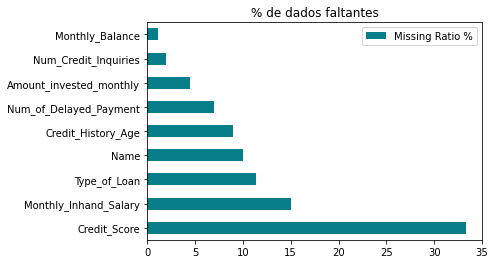

In [44]:
# Esta função define a quantidade % de dados faltantes
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh", color='#087E8B')
        plt.title("% de dados faltantes")
        plt.show()
    else:
        print('No NAs found')
        
plot_nas(df_total)

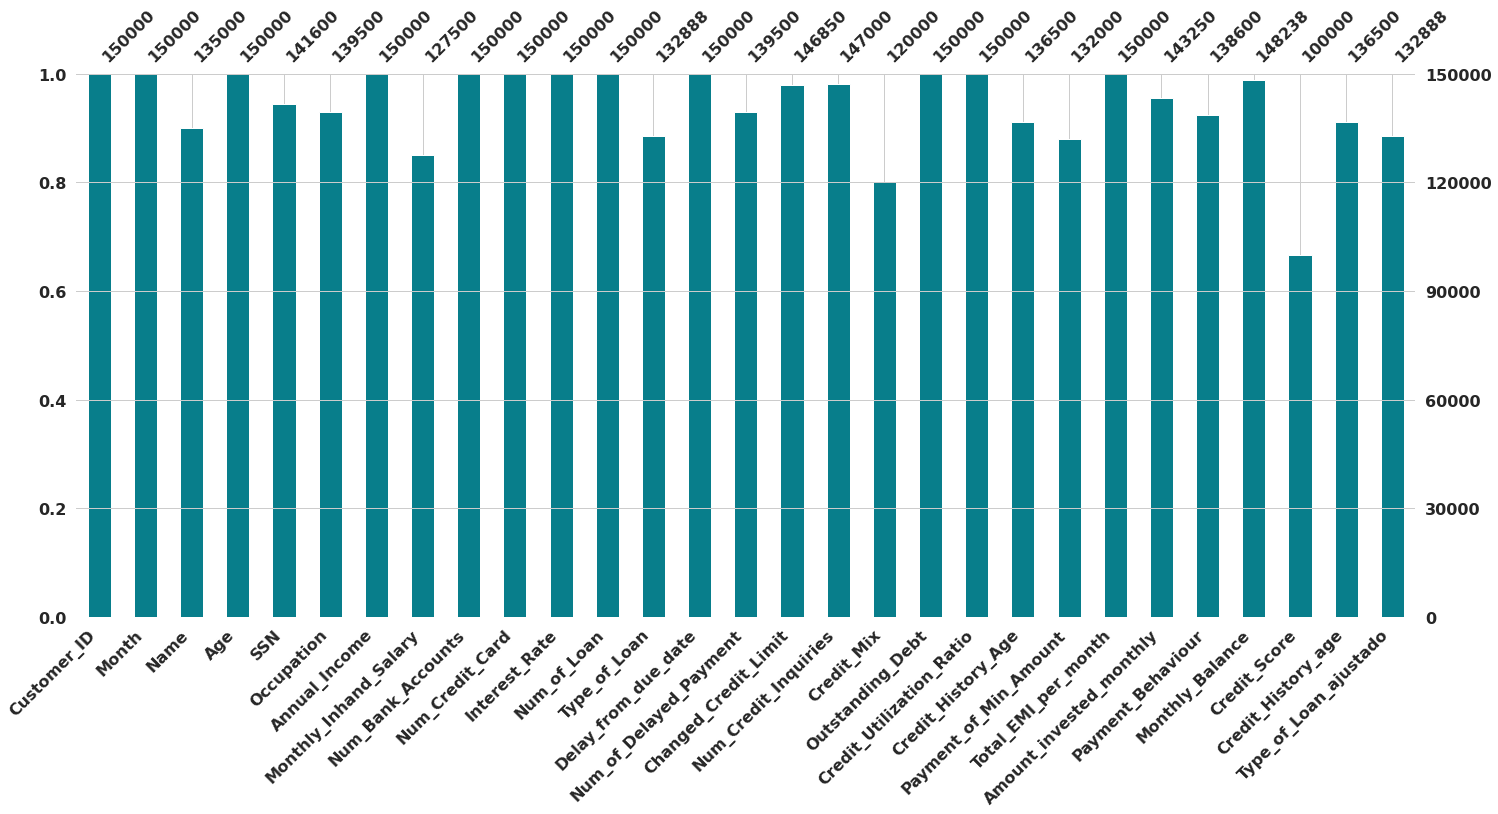

In [115]:
msno.bar(df_total, color='#087E8B');

## Checando os principais valores de algumas colunas

In [45]:
colunas = df_total.columns

for coluna in colunas:
    print('Variavel: ', coluna)
    print(20*'-')
    print(df_total[coluna].value_counts(dropna=False))

Variavel:  ID
--------------------
0x1569b    1
0x1bd69    1
0x16004    1
0xc407     1
0x706b     1
          ..
0x1e207    1
0x1e0fe    1
0x17357    1
0x14497    1
0xd009     1
Name: ID, Length: 150000, dtype: int64
Variavel:  Customer_ID
--------------------
CUS_0xa6b     12
CUS_0xa290    12
CUS_0x320d    12
CUS_0x2ed4    12
CUS_0xaf5c    12
              ..
CUS_0x8b98    12
CUS_0x4236    12
CUS_0x78e9    12
CUS_0xaf6f    12
CUS_0x294b    12
Name: Customer_ID, Length: 12500, dtype: int64
Variavel:  Month
--------------------
August       12500
September    12500
December     12500
February     12500
January      12500
June         12500
November     12500
April        12500
October      12500
March        12500
July         12500
May          12500
Name: Month, dtype: int64
Variavel:  Name
--------------------
NaN                  15000
Stevex                  66
Langep                  65
Jessicad                59
Vaughanl                58
                     ...  
Vellacotto    

### Observações

1. Colunas numéricas com "_" ok
    * Age,
    * Annual_Income,
    * Monthly_Inhand_Salary,
    * Num_Bank_Accounts,
    * Num_Credit_Card,
    * Interest_Rate
    * Num_of_Loan
    * Delay_from_due_date
    * Num_of_Delayed_Payment
    * Changed_Credit_Limit
    * Num_Credit_Inquiries
    * Outstanding_Debt
    * Credit_Utilization_Ratio
    * Total_EMI_per_month
    * Amount_invested_monthly
    * Monthly_Balance
2. SSN #F%$D@*&8 ok
3. Occupation _______ ok
4. Type_of_Loan - transformar em lista e indexar
5. Changed_Credit_Limit "_" -> NaN ok
6. Credit_Mix "_" -> NaN ok
7. Credit_History_Age Transformar em qtd. Meses
8. Payment_of_Min_Amount "NM" -> NaN ok
9. Payment_Behaviour "!@9#%8" -> NaN e transformar dado ok

<a id="title-two"></a>
<h1 style='background:#3f4788; border:2; border-radius: 10px; color:white;padding:20px'><center>Data Wrangling, EDA e Visualizações</center></h1>

## Ajustando os campos númericos que estão definidos como string por terem underlines em alguns registros

In [46]:
# Campos númericos que estão como string - retirar underline dos numeros

colunas_ul = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment',
              'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance']
for row in colunas_ul:
    df_total[row] = df_total[row].str.replace(r'_+', '')

## Data Wrangling

* Limpeza nos campos com dados inconsistentes

In [47]:
# Removendo coluna ID, completamente inútil para a análise
df_total.drop(['ID'], axis = 1, inplace = True)

# removendo caracter estranho do SSN
df_total['SSN'].replace('#F%$D@*&8', np.NaN, inplace=True)

# removendo os underlines e colocando NaN na coluna Occupation
df_total['Occupation'].replace('_______', np.NaN, inplace=True)

df_total['Changed_Credit_Limit'].replace(['_', ''], np.NaN, inplace=True)

df_total['Credit_Mix'].replace('_', np.NaN, inplace=True)

df_total['Payment_of_Min_Amount'].replace('NM', np.NaN, inplace=True)

df_total['Payment_Behaviour'].replace('!@9#%8', np.NaN, inplace=True)

### Convertendo campo de credit history para qtd. Meses
* 1 year = 12 months

In [48]:
# convertendo Credit_History_Age em quantidade de meses
def converter_mes(x):
    if pd.notnull(x):
        ano = int(x.split(' ')[0])
        mes = int(x.split(' ')[3])
        return (ano*12)+mes
    else:
        return x

df_total['Credit_History_age'] = df_total['Credit_History_Age'].apply(lambda x: converter_mes(x)).astype(float)

### Removendo 'and' no preenchimento do campo

In [49]:
df_total['Type_of_Loan_ajustado'] = df_total['Type_of_Loan'].replace("[abc]* and ", " ", regex=True)

### Conversão de dados

In [50]:
#criando dicionario e convertendo os dados

dicionario_conversao = {
    'Age': int,
    'Num_Bank_Accounts': int,
    'Num_Credit_Card': int,
    'Num_of_Loan': int,
    'Num_of_Delayed_Payment': int,
    'Annual_Income' : float,
    'Monthly_Inhand_Salary' : float,
    'Interest_Rate' : float,
    'Delay_from_due_date' : float,
    'Changed_Credit_Limit' : float,
    'Num_Credit_Inquiries' : float,
    'Outstanding_Debt' : float,
    'Credit_Utilization_Ratio' : float,
    'Changed_Credit_Limit' : float,
    'Amount_invested_monthly' : float,
    'Total_EMI_per_month' : float,
    'Num_of_Delayed_Payment' : float,
    'Monthly_Balance' : float,
    # 'ID' : object,
    'Customer_ID' : object,
    'Name' : object,
    'Month' : object,
    'SSN' : object,
    'Type_of_Loan' : object,
    'Occupation' : object,
    'Credit_Mix' : object,
    'Payment_of_Min_Amount' : object,
    'Payment_Behaviour' : object
    # 'test' : object
    }
# aplicando as type para variaveis

df_total = df_total.astype(dicionario_conversao)

In [51]:
# convertendo mes para encoding

import datetime

df_total['Month'] = df_total['Month'].apply(lambda x: datetime.datetime.strptime(x, '%B').month)

### Visualização dos dados pré-limpeza

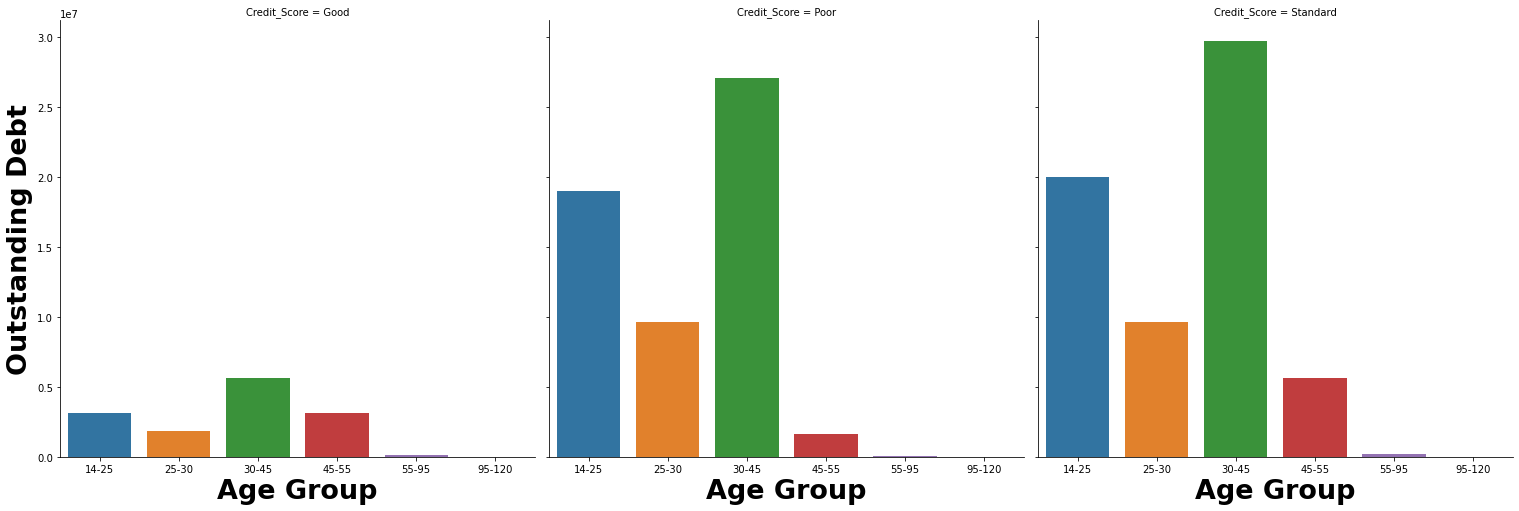

In [52]:
df2323 = df_total.copy()

df2323["Age_Group"] = pd.cut(
    df2323.Age,
    bins=[14, 25, 30, 45, 55, 95, 120],
    labels=["14-25", "25-30", "30-45", "45-55", "55-95", "95-120"],
                        )
age_groups = (
    df2323.groupby(["Age_Group", "Credit_Score"])[
        "Outstanding_Debt", "Annual_Income", "Num_Bank_Accounts", "Num_Credit_Card"
    ]
    .sum()
    .reset_index()
             )
g = sns.catplot(
    data=age_groups,
    x="Age_Group",
    y="Outstanding_Debt",
    height=7,
    aspect=1,
    col="Credit_Score",
    kind="bar",
    ci=None,
)
g.set_axis_labels("Age Group", "Outstanding Debt", size=27, fontweight="bold")
plt.show()

<Figure size 12960x432 with 0 Axes>

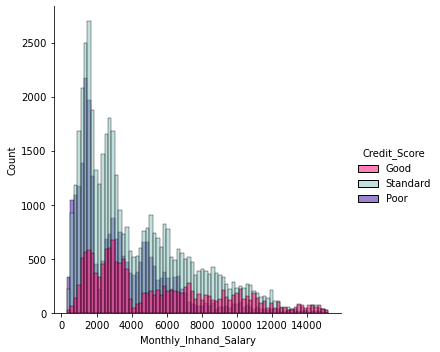

<Figure size 12960x432 with 0 Axes>

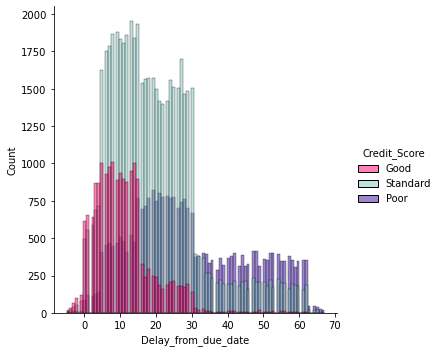

<Figure size 12960x432 with 0 Axes>

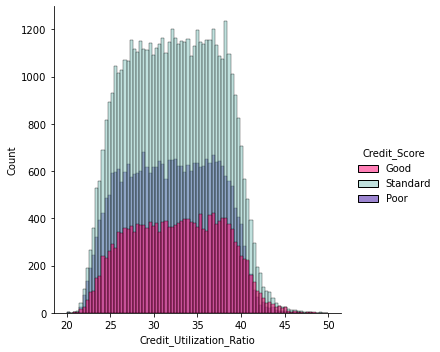

In [53]:
numCols = ['Monthly_Inhand_Salary', 'Delay_from_due_date', 'Credit_Utilization_Ratio']

for col in numCols:
    plt.figure(figsize=(180,6))
    sns.displot(x=col,data=df_total, hue='Credit_Score', palette=["#ff006e", "#83c5be", "#3a0ca3"])
    plt.show()

In [54]:
#dropando na

df_nonull = df_total.dropna()

# pegando indices

# df2 = df_nonull.groupby(["Customer_ID"])["Month"].nlargest(1)

# list comprehension para juntar os índices

# indice_final = [i[1] for i in df2.index.values]

# aplicando máscara, pegando somente linha do último mês de cada usuário

# df_nonull_uniqueCID = df_total.loc[indice_final]

df_nonull_uniqueCID = df_nonull.copy() #para não renomear todas a variáveis depois denovo

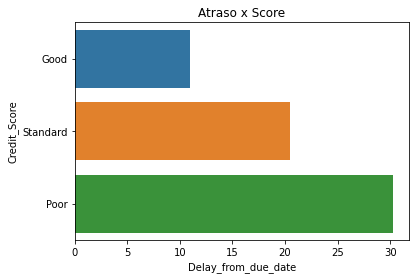

In [55]:
ordem1 = df_nonull_uniqueCID.groupby(['Credit_Score'])['Delay_from_due_date'].mean().sort_values().index

sns.barplot(data = df_nonull_uniqueCID,
            x='Delay_from_due_date',
            y='Credit_Score',
            ci = None,
            order = ordem1)
plt.title('Atraso x Score')
plt.show()

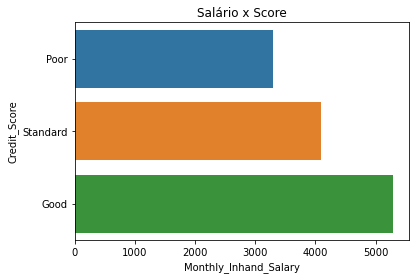

In [56]:
ordem2 = df_nonull_uniqueCID.groupby(['Credit_Score'])['Monthly_Inhand_Salary'].mean().sort_values().index

sns.barplot(data = df_nonull_uniqueCID,
            x='Monthly_Inhand_Salary',
            y='Credit_Score',
            ci = None,
            order = ordem2)

plt.title('Salário x Score')
plt.show()

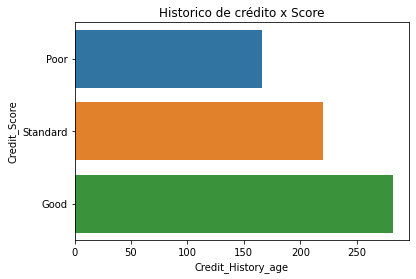

In [57]:
ordem2 = df_nonull_uniqueCID.groupby(['Credit_Score'])['Credit_History_age'].mean().sort_values().index

sns.barplot(data = df_nonull_uniqueCID,
            x='Credit_History_age',
            y='Credit_Score',
            ci = None,
            order = ordem2)

plt.title('Historico de crédito x Score')
plt.show()

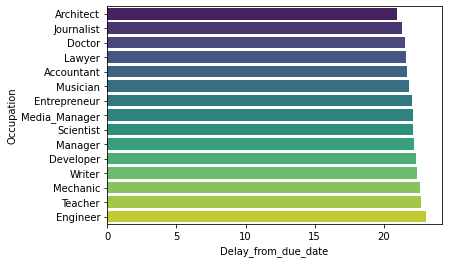

In [58]:
ordem1 = df_nonull_uniqueCID.groupby(['Occupation'])['Delay_from_due_date'].mean().sort_values().index

sns.barplot(data = df_nonull_uniqueCID,
            x='Delay_from_due_date',
            y='Occupation',
            ci = None,
            order = ordem1,
            palette='viridis')
plt.show()

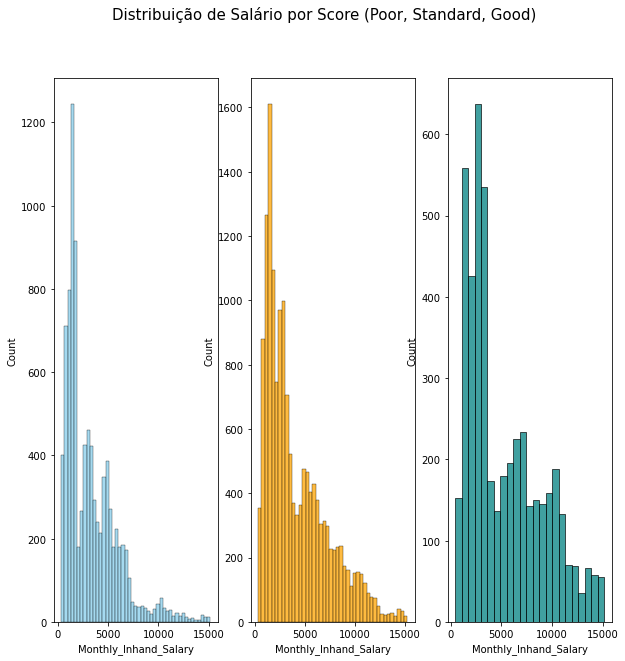

In [59]:
fig, axs = plt.subplots(1, 3, figsize = (10,10))

sns.histplot(data = df_nonull_uniqueCID[df_nonull_uniqueCID['Credit_Score'] == 'Poor'], x = 'Monthly_Inhand_Salary', ax = axs[0], color = 'skyblue')
sns.histplot(data = df_nonull_uniqueCID[df_nonull_uniqueCID['Credit_Score'] == 'Standard'], x = 'Monthly_Inhand_Salary', ax = axs[1], color = 'orange')
sns.histplot(data = df_nonull_uniqueCID[df_nonull_uniqueCID['Credit_Score'] == 'Good'], x = 'Monthly_Inhand_Salary', ax = axs[2], color = 'teal')

fig.suptitle('Distribuição de Salário por Score (Poor, Standard, Good)', size = 15)
plt.show()


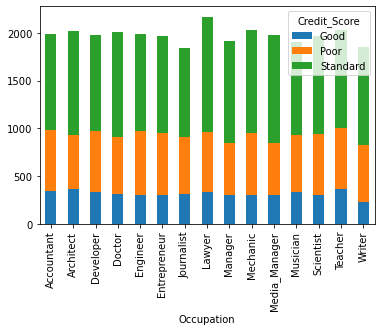

In [60]:
df_plot = df_nonull_uniqueCID.groupby(['Occupation', 'Credit_Score']).size().reset_index().pivot(columns='Credit_Score', index='Occupation', values=0)

df_plot.plot(kind='bar', stacked=True)
plt.show()

In [61]:
# numCols = df_total.select_dtypes([np.number]).columns

# for col in numCols:
#     fig, ax = plt.subplots(1, 2, figsize = (8,8))
#     sns.boxplot(data=df_total, y=col, x = 'Credit_Score', ax=ax[0])
#     sns.scatterplot(data=df_total,x = 'Credit_Score', s = 100, y=col, ax=ax[1], color ='#ee1199')
#     plt.show()

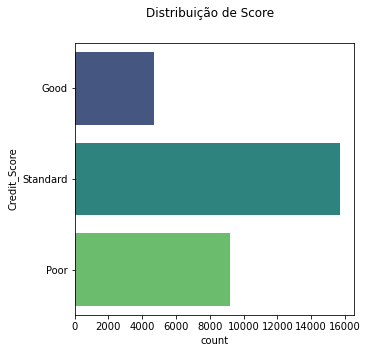

In [63]:
label = df_total.Credit_Score.value_counts().index
label_count = df_nonull_uniqueCID.Credit_Score.value_counts().values
plt.figure(figsize=(5,5))
sns.countplot(data=df_nonull_uniqueCID, y='Credit_Score', palette='viridis')
plt.suptitle("Distribuição de Score")
plt.show()

In [64]:
# plt.figure(figsize=(20,18))
# sns.heatmap(df_total.corr(),annot=True,cmap='viridis', linewidths=1, linecolor='k', fmt='.2f')

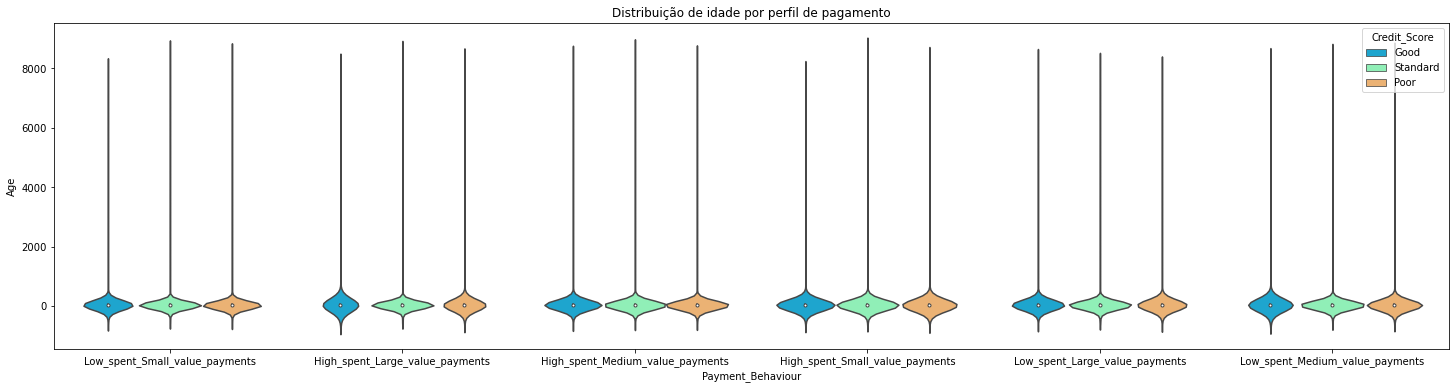

In [65]:
plt.figure(figsize=(25,6))
sns.violinplot(x='Payment_Behaviour',y='Age',data=df_nonull_uniqueCID, hue='Credit_Score', palette='rainbow')
plt.title("Distribuição de idade por perfil de pagamento")
plt.show()

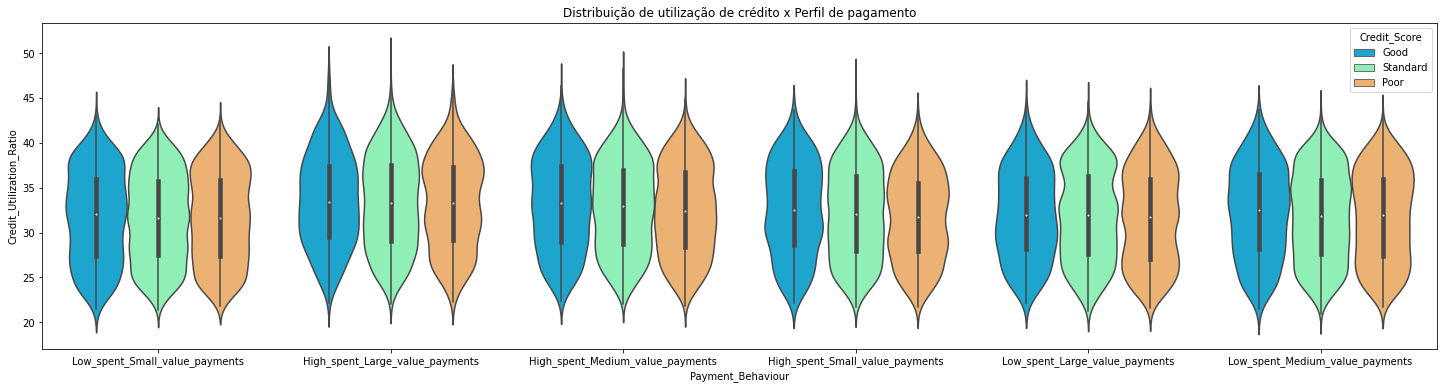

In [66]:
plt.figure(figsize=(25,6))
sns.violinplot(x='Payment_Behaviour',y='Credit_Utilization_Ratio',data=df_nonull_uniqueCID, hue='Credit_Score', palette='rainbow')
plt.title("Distribuição de utilização de crédito x Perfil de pagamento")
plt.show()

<Figure size 4248x72 with 0 Axes>

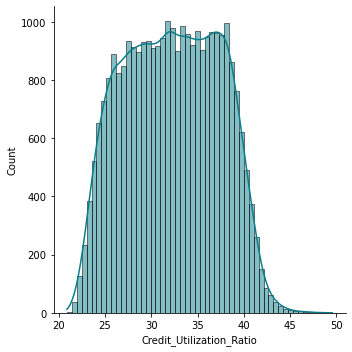

In [67]:
plt.figure(figsize=(59,1))
sns.displot(data=df_nonull_uniqueCID, x="Credit_Utilization_Ratio", kde=True, color='#087E8B')

In [68]:
nome_dict = {'Month': 'Mês',
             'Age': 'Idade',
             'Annual_Income': 'Renda Anual',
             'Monthly_Inhand_Salary': 'Salário Mensal',
             'Num_Bank_Accounts': 'Qtd. Contas',
             'Num_Credit_Card': 'Qtd. Cartões',
             'Interest_Rate': 'Taxa de Juros',
             'Num_of_Loan': 'Qtd. Empréstimos',
             'Delay_from_due_date': 'Atraso no pgto.',
             'Num_of_Delayed_Payment': 'Qtd. Atrasos',
             'Changed_Credit_Limit': 'Fator de troca do Limite de Crédito',
             'Num_Credit_Inquiries': 'Qtd. de Cobranças',
             'Outstanding_Debt': 'Dívida Pendente',
             'Credit_Utilization_Ratio': 'Taxa de Utilização de Crédito',
             'Total_EMI_per_month': 'Valor mensal prestação',
             'Amount_invested_monthly': 'Valor investido mensalmente',
             'Monthly_Balance': 'Saldo mensal',
             'Credit_History_age': 'Idade de Histórico de Crédito'}

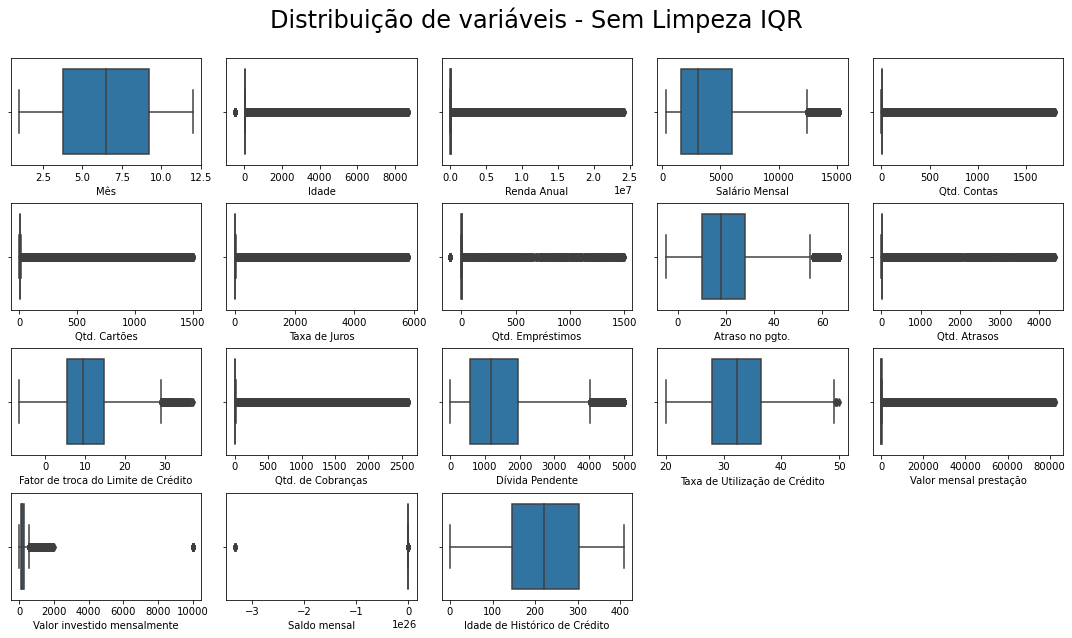

In [69]:
fig = plt.figure(figsize= (15,9))

num_cols = list(df_nonull_uniqueCID.select_dtypes(exclude='object').columns)

for i, col in enumerate(num_cols):
    ax=fig.add_subplot(4,5,i+1)      
    sns.boxplot(x=df_total[col], ax=ax)
    plt.xlabel(nome_dict[col])
    fig.tight_layout()

fig.suptitle('Distribuição de variáveis - Sem Limpeza IQR\n', size = 24)
plt.subplots_adjust(top=0.90)
plt.show()

<a id="title-three"></a>
<h1 style='background:#3f4788; border:2; border-radius: 10px; color:white;padding:20px'><center>Limpeza de Dados</center></h1>

### Limpando outliers

* Idade - Clientes entre 18 e 100 anos;
* IQR nas variáveis numéricas.

In [70]:
# aplicando IQR para as colunas numéricas
# a coluna age sera tratada limitando idades entre 0 e 100 anos

print('Número de linhas pré-limpeza: ', df_nonull_uniqueCID.shape[0])

# Age

indice_age = df_nonull_uniqueCID[(df_nonull_uniqueCID['Age'] <= 18) | (df_nonull_uniqueCID['Age'] >= 100)].index

df_nonull_uniqueCID.drop(indice_age, inplace=True)

# Restante das colunas numéricas

for i in ['Num_of_Loan', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Delay_from_due_date', 'Annual_Income',
          'Interest_Rate', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Total_EMI_per_month',
          'Amount_invested_monthly', 'Monthly_Balance']:

    q1, q3 = np.percentile(df_nonull_uniqueCID[i], [25, 75])
    
    iqr = q3 - q1
    lim_inf = q1 - 1.5 * iqr
    lim_sup = q3 + 1.5 * iqr
    indice = df_nonull_uniqueCID[(df_nonull_uniqueCID[i] <= 0) | (df_nonull_uniqueCID[i] >= lim_sup)].index
    df_nonull_uniqueCID.drop(indice, inplace=True)

print('Número de linhas pós limpeza: ', df_nonull_uniqueCID.shape[0])

Número de linhas pré-limpeza:  29664
Número de linhas pós limpeza:  14333


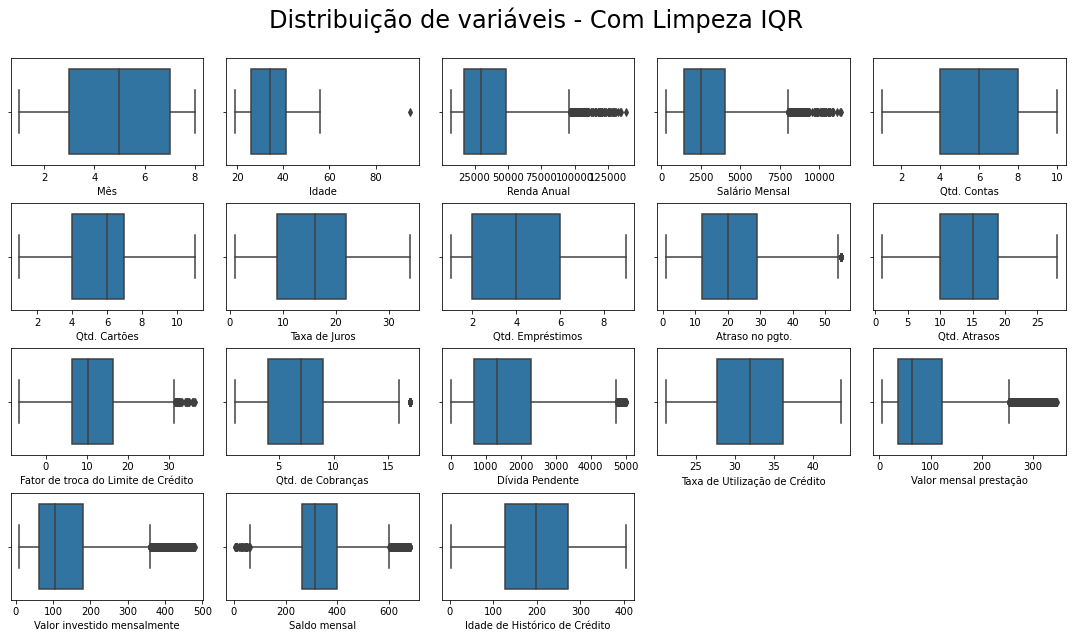

In [71]:
fig = plt.figure(figsize= (15,9))

for i, col in enumerate(num_cols):
    ax=fig.add_subplot(4,5,i+1)      
    sns.boxplot(x=df_nonull_uniqueCID[col], ax=ax)
    plt.xlabel(nome_dict[col])
    fig.tight_layout()

fig.suptitle('Distribuição de variáveis - Com Limpeza IQR\n', size = 24)
plt.subplots_adjust(top=0.90)
plt.show()

<a id="title-four"></a>
<h1 style='background:#3f4788; border:2; border-radius: 10px; color:white;padding:20px'><center>Pré-processamento de Dados</center></h1>

### Drops vars. inúteis, Normalização, Encoding, Splits etc.

In [72]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

df_processado = df_nonull_uniqueCID.copy()
df_processado = df_processado.drop(['Customer_ID', 'Name', 'SSN', 'Type_of_Loan', 'Type_of_Loan_ajustado',
                                    'Credit_History_Age', 'Credit_Score', 'Month', 'Monthly_Balance',
                                    'Occupation', 'Payment_Behaviour'], axis=1)

#Pegando variáveis categóricas e numéricas

categorical = list(df_processado.select_dtypes(include=['object']).columns)  #Talvez criar no começo pra visualizaçao describe().transpose()
numerical = list(df_processado.select_dtypes(include=['int64', 'float64']).columns) #Talvez criar no começo pra visualizaçao describe()

# Dummy Encoder para variáveis categóricas

df_processado_categoricals = pd.DataFrame(columns = categorical, index = df_processado.index)
for col in df_processado.select_dtypes('object'):
    df_processado_categoricals[col], _ = df_processado[col].factorize()

#Scaling para variáveis numéricas

from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()

df_processado_numericals = pd.DataFrame(stdscaler.fit_transform(df_processado[numerical]), columns = numerical, index = df_processado_categoricals.index)

#Concatenando categóricas encodadas e numéricas escaladas

df_processado_final = pd.concat([df_processado_numericals, df_processado_categoricals], axis=1)

#Ordinal Encoder na target

from sklearn.preprocessing import OrdinalEncoder
ordenc = OrdinalEncoder()

df_processado_final['Credit_Score'] = ordenc.fit_transform(df_nonull_uniqueCID['Credit_Score'].values.reshape(-1,1)).astype(int)

#Definindo X e y

X = df_processado_final.drop(['Credit_Score'], axis = 1)
y = df_processado_final['Credit_Score']

X_todas_feats = df_nonull_uniqueCID.drop(['Customer_ID', 'Name', 'SSN', 'Type_of_Loan', 'Type_of_Loan_ajustado'], axis=1)
for col in X_todas_feats.select_dtypes('object'):
    X_todas_feats[col], _ = X_todas_feats[col].factorize()
    
for col in X_todas_feats.select_dtypes(['int64', 'float64']):
    X_todas_feats[col] = stdscaler.fit_transform(X_todas_feats[col].values.reshape(-1,1))

#Splitando o dataframe processado

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

X_train_todas_feats, X_test_todas_feats, y_train_todas_feats, y_test_todas_feats = train_test_split(X_todas_feats, y, test_size=0.2, stratify = y, random_state=42)

print('Shape dos splits com features seleciondadas (X_train, X_test, y_train, y_test): ')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('\nShape dos splits com todas as features ("): ')
print(X_train_todas_feats.shape, X_test_todas_feats.shape, y_train_todas_feats.shape, y_test_todas_feats.shape)

Shape dos splits com features seleciondadas (X_train, X_test, y_train, y_test): 
(11466, 14) (2867, 14) (11466,) (2867,)

Shape dos splits com todas as features ("): 
(11466, 24) (2867, 24) (11466,) (2867,)


In [73]:
print('Encoding da target: ',{'0': ordenc.categories_[0][0],
       '1': ordenc.categories_[0][1],
       '2': ordenc.categories_[0][2]})

Encoding da target:  {'0': 'Good', '1': 'Poor', '2': 'Standard'}


<a id="title-five"></a>
<h1 style='background:#3f4788; border:2; border-radius: 10px; color:white;padding:20px'><center>Feature Importance e Feature Selection</center></h1>

In [74]:
df_processado_final.columns

Index(['Annual_Income', 'Monthly_Inhand_Salary', 'Interest_Rate',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Total_EMI_per_month', 'Amount_invested_monthly', 'Credit_History_age',
       'Credit_Mix', 'Payment_of_Min_Amount', 'Credit_Score'],
      dtype='object')

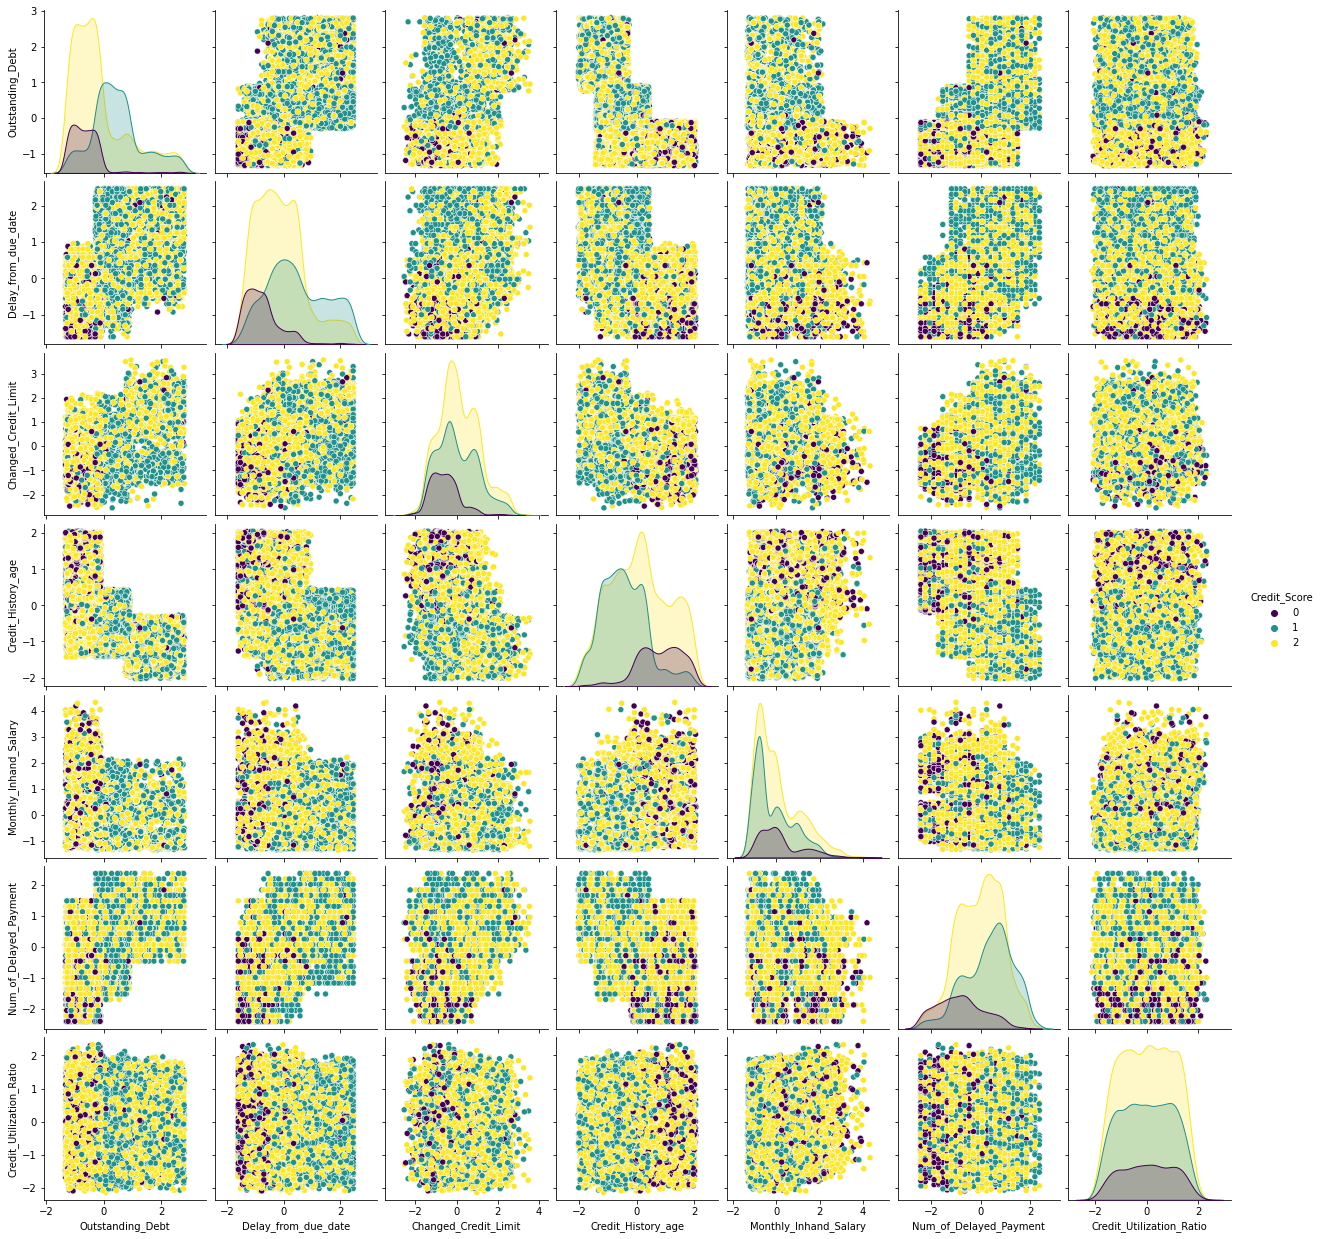

In [75]:
feat_imp = ['Outstanding_Debt','Delay_from_due_date','Changed_Credit_Limit','Credit_History_age',
            'Monthly_Inhand_Salary','Num_of_Delayed_Payment','Credit_Utilization_Ratio', 'Credit_Score']

sns.pairplot(df_processado_final[feat_imp], hue='Credit_Score', palette='viridis')

In [76]:
def Distribution(columne,data,i):
    fig, ax = plt.subplots(1,2, figsize = (15,5))
    font_dict = {'fontsize': 14}
    title=['Antes do processamento','Depois do processamento']
    ax = np.ravel(ax)
    if i==1:
        sns.set(style='whitegrid')
        sns.kdeplot(data=data,x=columne, ax = ax[0],color='r').set_title(title[i])
        sns.boxplot(data=data,x=columne, ax = ax[1],palette='magma').set_title(title[i])
    else:
        sns.set(style='whitegrid')
        sns.kdeplot(data=data,x=columne, ax = ax[0],color='#2171b5').set_title(title[i])
        sns.boxplot(data=data,x=columne, ax = ax[1],color='#2171b5').set_title(title[i])
        
    ax = np.reshape(ax, (1, 2))
    plt.tight_layout()

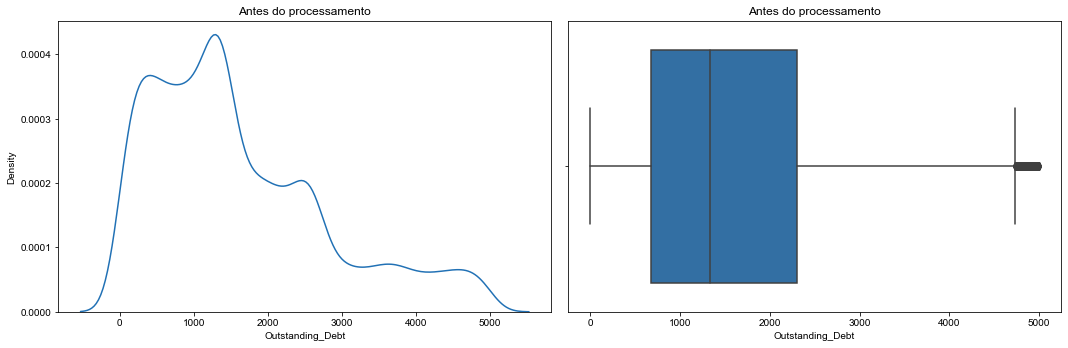

In [77]:
Distribution(columne = 'Outstanding_Debt', data = df_nonull_uniqueCID, i = 0)

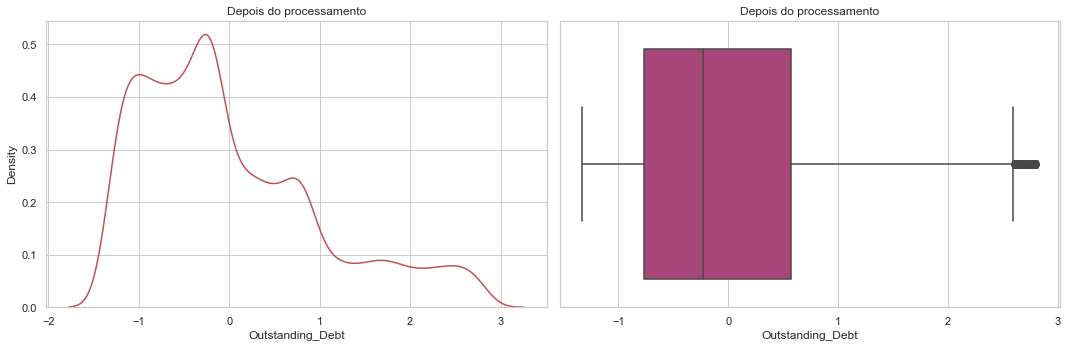

In [78]:
Distribution(columne = 'Outstanding_Debt', data = df_processado_final, i = 1)

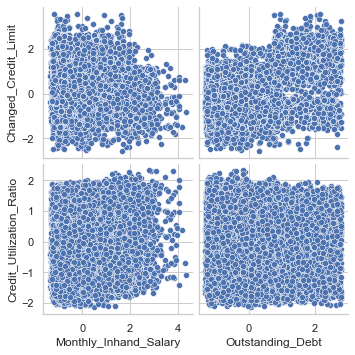

In [79]:
from turtle import color


sns.pairplot(df_processado_final,
             x_vars=['Monthly_Inhand_Salary','Outstanding_Debt'],
             y_vars=['Changed_Credit_Limit','Credit_Utilization_Ratio'])

<a id="title-five"></a>
<h1 style='background:#3f4788; border:2; border-radius: 10px; color:white;padding:20px'><center>Feature Selection e Feature Importance</center></h1>

In [80]:
# Modelo Statsmodels para teste de hipótese e seleção de features

# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train)
non_reg_OLS = model.fit()
non_reg_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           Credit_Score   R-squared (uncentered):                   0.826
Model:                            OLS   Adj. R-squared (uncentered):              0.826
Method:                 Least Squares   F-statistic:                              3888.
Date:                Sun, 16 Oct 2022   Prob (F-statistic):                        0.00
Time:                        15:14:29   Log-Likelihood:                         -11499.
No. Observations:               11466   AIC:                                  2.303e+04
Df Residuals:                   11452   BIC:                                  2.313e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Annual_Income                0.2423      0.070      3.451      0.001       0.105       0.380
Monthly_Inhand_Salary       -0.1626      0.070     -2.335      0.020      -0.299      -0.026
Interest_Rate               -0.1617      0.009    -18.088      0.000      -0.179      -0.144
Delay_from_due_date         -0.1252      0.008    -15.566      0.000      -0.141      -0.109
Num_of_Delayed_Payment      -0.1529      0.008    -19.278      0.000      -0.168      -0.137
Changed_Credit_Limit         0.1050      0.007     14.325      0.000       0.091       0.119
Num_Credit_Inquiries        -0.1593      0.009    -18.174      0.000      -0.176      -0.142
Outstanding_Debt            -0.1931      0.010    -19.242      0.000      -0.213      -0.173
Credit_Utilization_Ratio    -0.0012      0.006     -0.194      0.846      -0.013       0.011
Total_EMI_per_month         -0.0768      0.010     -7.946      0.000      -0.096      -0.058
Amount_invested_monthly      0.0113      0.008      1.483      0.138      -0.004       0.026
Credit_History_age           0.0697      0.009      7.815      0.000       0.052       0.087
Credit_Mix                   0.9655      0.014     68.792      0.000       0.938       0.993
Payment_of_Min_Amount        0.4315      0.021     20.682      0.000       0.391       0.472
==============================================================================
Omnibus:                      136.999   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.563
Skew:                          -0.265   Prob(JB):                     3.00e-31
Kurtosis:                       2.882   Cond. No.                         35.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
#VIF
def calc_vif(data):
    vif_df = pd.DataFrame(columns=['Var', 'VIF'])
    x_var_names = data.columns
    
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop(x_var_names[i])]
        r2 = sm.OLS(y, x).fit().rsquared
        vif = round(1/(1-r2),3)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by='VIF',axis = 0, ascending=False, inplace=False)

calc_vif(X_train)

,Var,VIF
0,Annual_Income,132.005
1,Monthly_Inhand_Salary,129.726
12,Credit_Mix,8.722
13,Payment_of_Min_Amount,8.175
7,Outstanding_Debt,2.649
9,Total_EMI_per_month,2.490
2,Interest_Rate,2.115
11,Credit_History_age,2.091
6,Num_Credit_Inquiries,2.028
3,Delay_from_due_date,1.703


### * ExtraTreeClassifier - método model.feature_importances_

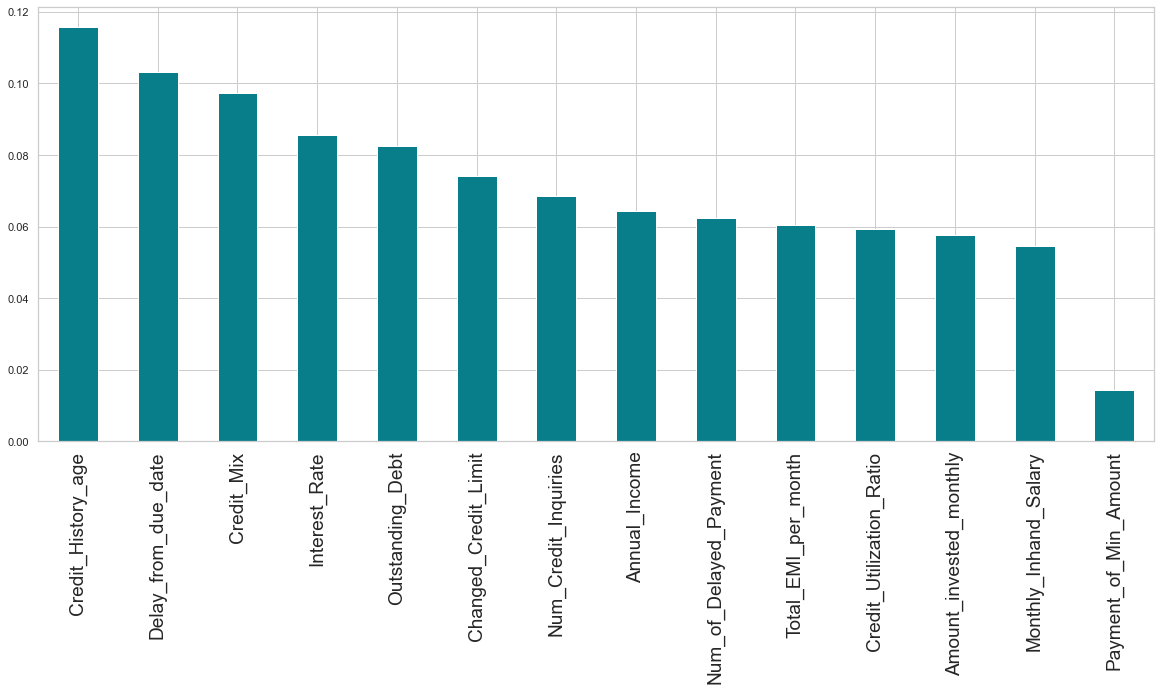

In [82]:
#ExtraTreeClassifier para feature_importances_

from sklearn.tree import ExtraTreeClassifier

xtc = ExtraTreeClassifier()
xtc.fit(X_train, y_train)
feat_importance = pd.Series(xtc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(20,8))
feat_importance.plot(kind='bar', color='#087E8B')
plt.xticks(fontsize=19);

### *PCA - Visualização e Feature Importance

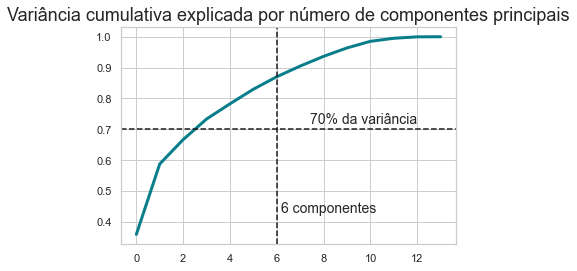

In [83]:
# Visualização da Análise de Componentes Principais (PCA)
from sklearn.decomposition import PCA

pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.axhline(0.7, ls='--', color='k')
plt.axvline(6, ls='--', color='k')
plt.text(7.4, 0.72, '70% da variância', fontsize=14)
plt.text(6.2, 0.43, '6 componentes', fontsize=14)
plt.title('Variância cumulativa explicada por número de componentes principais', size=18)
plt.show()

In [84]:
print('Número de componentes principais para explicar pelo menos 70% da variância: {}'.format(np.argmax(pca.explained_variance_ratio_.cumsum() > 0.7)))
print(f'9 Componentes principais explicam: {pca.explained_variance_ratio_[:10].sum().round(4)*100}% da variância')

Número de componentes principais para explicar pelo menos 70% da variância: 3
9 Componentes principais explicam: 96.38% da variância


<AxesSubplot:>

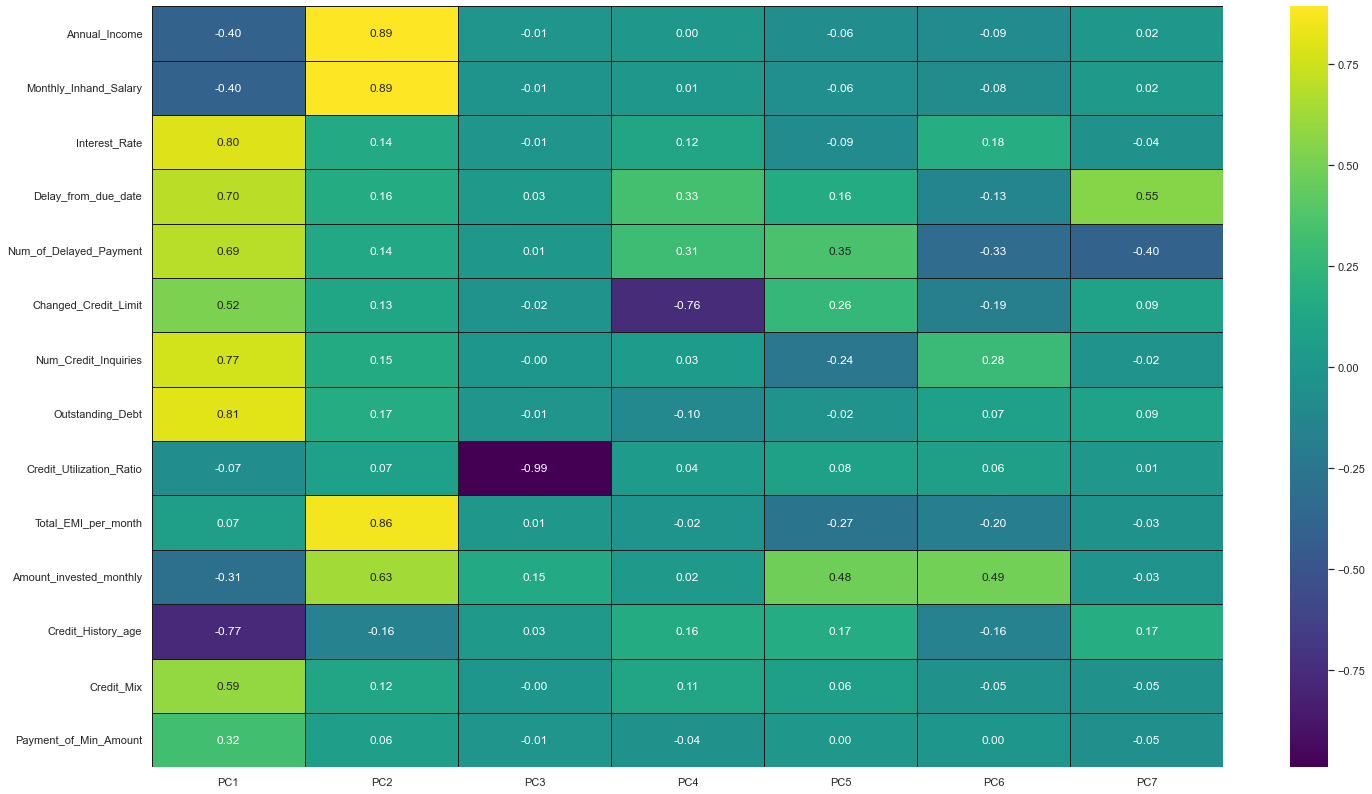

In [85]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(X_train.columns) + 1)],
    index=X_train.columns
)

plt.figure(figsize=(24,14))
sns.heatmap(loadings.iloc[:,:7], annot=True, cmap='viridis', linewidths=1, linecolor='k', fmt='.2f')

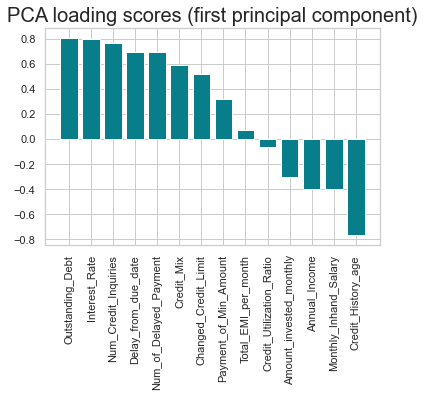

In [86]:
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')
plt.show()

Outstanding_Debt            0.316999
Annual_Income               0.250251
Monthly_Inhand_Salary       0.228007
Total_EMI_per_month         0.219415
Interest_Rate               0.173248
Credit_Mix                  0.170616
Num_Credit_Inquiries        0.115512
Changed_Credit_Limit        0.103424
Payment_of_Min_Amount       0.099930
Credit_History_age          0.098239
Delay_from_due_date         0.097946
Num_of_Delayed_Payment      0.065998
Credit_Utilization_Ratio    0.006504
Amount_invested_monthly     0.002100
Name: MI Scores, dtype: float64


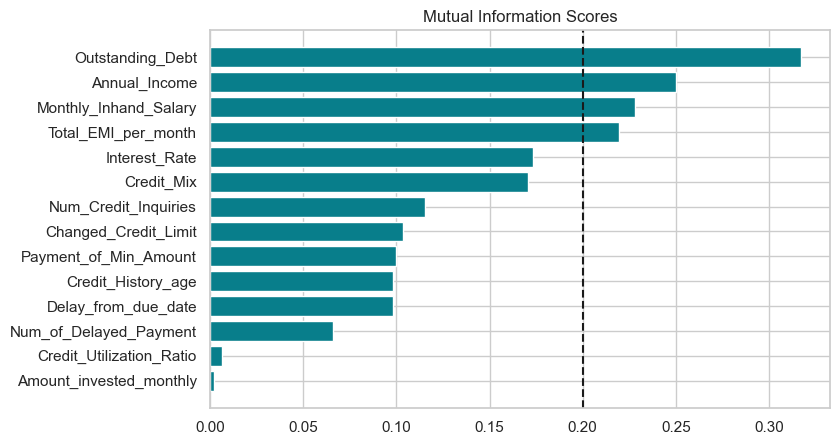

In [87]:
from turtle import color
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores, color='#087E8B')
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

discrete_features = X.dtypes == int
mi_scores = make_mi_scores(X, y, discrete_features)

print(mi_scores)
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)
plt.axvline(0.2, color='k', linestyle='--')

### Meme do homem-aranha apontando pro homem-aranha

<img src='img/meme-homem-aranha.JPG' width=30% height=40%>

<a id="title-six"></a>
<h1 style='background:#3f4788; border:2; border-radius: 10px; color:white;padding:20px'><center>Modelagem</center></h1>

In [88]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, accuracy_score


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.dummy import DummyClassifier

from skopt import BayesSearchCV

In [89]:
# Criando comparação de acurácia entre os 5 modelos escolhidos

comparacao_modelos = pd.DataFrame(columns = ['Modelo', 'Score'])

modelos = [LogisticRegression(solver='liblinear', random_state=42),
           KNeighborsClassifier(n_neighbors=41, p=4),
           DecisionTreeClassifier(random_state=42),
           RandomForestClassifier(random_state=42),
           XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
           ExtraTreeClassifier(random_state=42),
           MLPClassifier(solver='sgd', random_state=42, max_iter=500),
           ]

for model in modelos:
    model_name = model.__class__.__name__
    scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'accuracy')
    comparacao_modelos.loc[len(comparacao_modelos)] = [model_name, scores.mean().round(4)]

print('* Comparação Cross-Validation-Score entre vários modelos: ')
comparacao_modelos

c:\Users\Felipe\anaconda3\envs\dhdsblend2022_main\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Felipe\anaconda3\envs\dhdsblend2022_main\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


* Comparação Cross-Validation-Score entre vários modelos: 


,Modelo,Score
0,LogisticRegression,0.6705
1,KNeighborsClassifier,0.7043
2,DecisionTreeClassifier,0.6676
3,RandomForestClassifier,0.7659
4,XGBClassifier,0.7495
5,ExtraTreeClassifier,0.6599
6,MLPClassifier,0.7207


### Modelo Baseline: Dummy Classifier

In [90]:
dummymodel = DummyClassifier(strategy='prior')
dummymodel.fit(X_train, y_train)

y_pred_dummy = dummymodel.predict(X_test)

0.5409836065573771


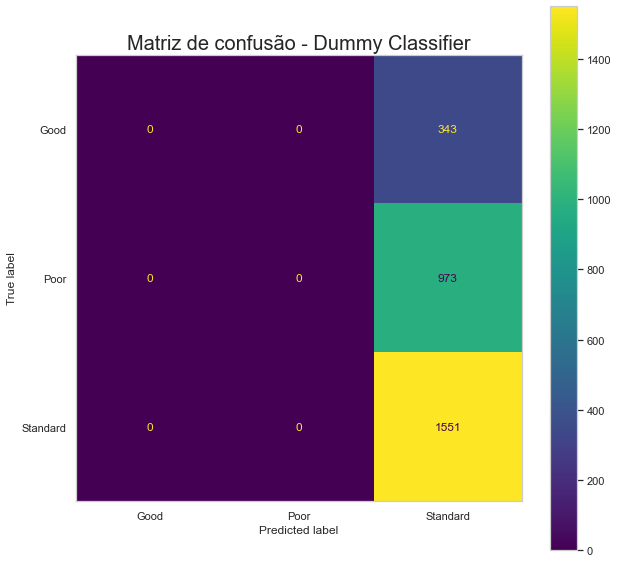

In [91]:
print(accuracy_score(y_test, y_pred_dummy))
cmp1 = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_dummy), display_labels=['Good', 'Poor', 'Standard'])
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(False)
cmp1.plot(ax=ax)
plt.rc('font', **font)
plt.title('Matriz de confusão - Dummy Classifier', fontsize = 20)
plt.show()

In [92]:
r_auc_dummy = roc_auc_score(y_test, dummymodel.predict_proba(X_test), multi_class = 'ovo')
print('Dummy Classifier tem AUROC = %.3f' % (r_auc_dummy))

Dummy Classifier tem AUROC = 0.500


### 1º Modelo: Extra Trees Classifier

In [93]:
# #Otimização Bayesiana de hiperparâmetros
# xtclf = ExtraTreesClassifier(n_jobs=-1)
# xt_params = {'n_estimators':[2000],
#                 'criterion': ['gini'],
#                 'bootstrap':[True]
#                 }

# bayessearch_xt = BayesSearchCV(xtclf,
#                                   xt_params,
#                                   cv=5,
#                                   refit=['accuracy', 'f1'],
#                                   n_jobs=-1,
#                                   verbose=1,
#                                   random_state=42
#                                   ).fit(X_train, y_train)

# y_pred_xt = bayessearch_xt.predict(X_test)
# bayessearch_xt.best_params_

In [94]:
# OrderedDict([('bootstrap', True),
#              ('criterion', 'gini'),
#              ('n_estimators', 2000)])

xtclf = ExtraTreesClassifier(n_jobs=-1,
                             bootstrap=True,
                             criterion='gini',
                             n_estimators=2000).fit(X_train, y_train)

y_pred_xt = xtclf.predict(X_test)

              precision    recall  f1-score   support

           0       0.65      0.73      0.69       343
           1       0.77      0.74      0.76       973
           2       0.81      0.80      0.80      1551

    accuracy                           0.77      2867
   macro avg       0.74      0.76      0.75      2867
weighted avg       0.77      0.77      0.77      2867



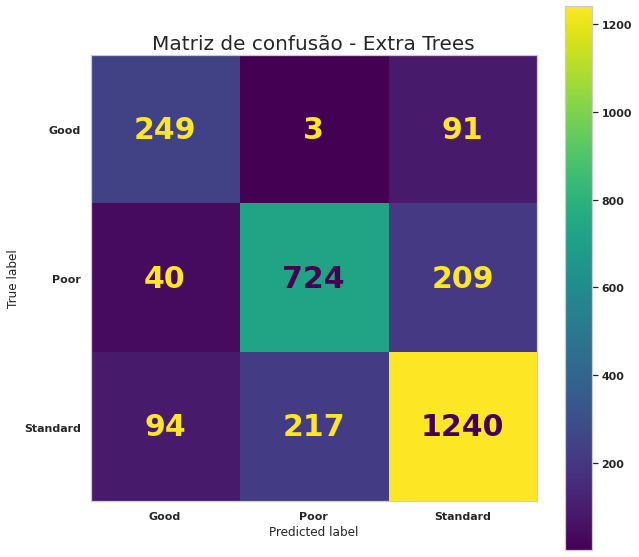

In [95]:
print(classification_report(y_test, y_pred_xt))
cmp1 = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xt), display_labels=['Good', 'Poor', 'Standard'])
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(False)
cmp1.plot(ax=ax)
plt.rc('font', **font)
plt.title('Matriz de confusão - Extra Trees', fontsize = 20)
plt.show()

In [96]:
r_auc_xt = roc_auc_score(y_test, xtclf.predict_proba(X_test), multi_class = 'ovo')
print('Extra Trees tem AUROC = %.3f' % (r_auc_xt))

Extra Trees tem AUROC = 0.899


### 2º Modelo: Random Forest

In [97]:
# #Otimização Bayesiana de hiperparâmetros
# rfclassifier = RandomForestClassifier(random_state = 42, n_jobs = -1)
# rf_params = {'n_estimators': [500, 1500],
#               'max_depth': [None],
#               'criterion': ['gini']
#                }

# bayessearch_rf = BayesSearchCV(rfclassifier,
#                                rf_params,
#                                cv = 5,
#                                scoring = 'accuracy',
#                                n_jobs = -1,
#                                verbose = 1,
#                                refit = 'accuracy'
#                                ).fit(X_train, y_train)

# y_pred_rf = bayessearch_rf.predict(X_test)
# bayessearch_rf.best_params_

In [98]:
# OrderedDict([('criterion', 'gini'),
#              ('max_depth', None),
#              ('n_estimators', 1441)])

rfclf = RandomForestClassifier(random_state = 42,
                               n_jobs = -1,
                               criterion = 'gini',
                               max_depth = None,
                               n_estimators = 1441).fit(X_train, y_train)

y_pred_rf = rfclf.predict(X_test)

              precision    recall  f1-score   support

           0       0.68      0.72      0.70       343
           1       0.76      0.76      0.76       973
           2       0.81      0.80      0.80      1551

    accuracy                           0.78      2867
   macro avg       0.75      0.76      0.76      2867
weighted avg       0.78      0.78      0.78      2867



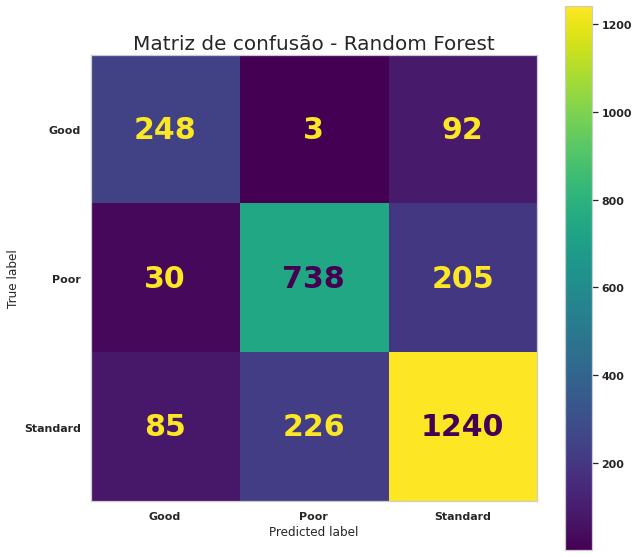

In [99]:
print(classification_report(y_test, y_pred_rf))
cmp1 = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf), display_labels=['Good', 'Poor', 'Standard'])
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(False)
cmp1.plot(ax=ax)
plt.rc('font', **font)
plt.title('Matriz de confusão - Random Forest', fontsize = 20)
plt.show()

In [100]:
r_auc_rf = roc_auc_score(y_test, rfclf.predict_proba(X_test), multi_class = 'ovo')
print('Random Forest tem AUROC = %.3f' % (r_auc_rf))

Random Forest tem AUROC = 0.897


### 3º Modelo: XGBoost

In [101]:
# #Otimização Bayesiana de hiperparâmetros
# xgbclassifier = XGBClassifier(eval_metric = 'logloss', use_label_encoder = False, random_state = 42)

# xgb_params = {'n_estimators': [5, 750, 1500],
#               'max_depth': [None],
#               'gamma': [0.5, 1, 5],
#               'subsample': [0.2, 1.0],
#               'colsample_bytree': [0.6, 0.8],
#               'min_child_weight': [0.3, 0.7, 1.0],
#               'learning_rate': [0.1, 0.3]
#                }

# OrderedDict([('colsample_bytree', 0.6),
#              ('gamma', 1.0),
#              ('learning_rate', 0.1),
#              ('max_depth', None),
#              ('min_child_weight', 0.7),
#              ('n_estimators', 1500),
#              ('subsample', 1.0)])

# bayessearch_xgbc = BayesSearchCV(xgbclassifier,
#                                  xgb_params,
#                                  cv = 5,
#                                  scoring = 'accuracy',
#                                  refit = 'accuracy',
#                                  verbose = 1,
#                                  n_jobs = -1
#                                  ).fit(X_train, y_train)

# y_pred_xgbc = bayessearch_xgbc.predict(X_test)
# bayessearch_xgbc.best_params_

In [102]:
xgbclassifier = XGBClassifier(eval_metric = 'logloss',
                              use_label_encoder = False,
                              random_state = 42,
                              colsample_bytree = 0.6,
                              gamma = 1.0,
                              learning_rate = 0.1,
                              max_depth = None,
                              min_child_weight = 0.7,
                              n_estimators = 1500,
                              subsample = 1.0).fit(X_test, y_test)

y_pred_xgbc = xgbclassifier.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       343
           1       0.96      0.95      0.96       973
           2       0.96      0.97      0.97      1551

    accuracy                           0.96      2867
   macro avg       0.97      0.96      0.97      2867
weighted avg       0.96      0.96      0.96      2867



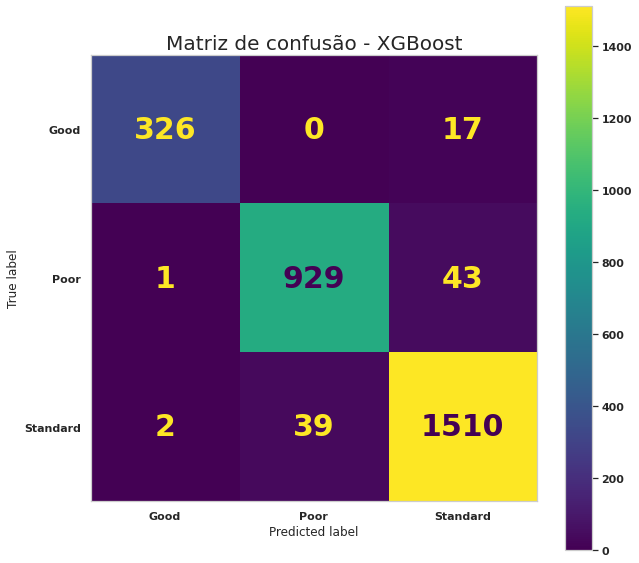

In [103]:
print(classification_report(y_test, y_pred_xgbc))
cmp1 = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgbc), display_labels=['Good', 'Poor', 'Standard'])
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(False)
cmp1.plot(ax=ax)
plt.rc('font', **font)
plt.title('Matriz de confusão - XGBoost', fontsize = 20)
plt.show()

In [104]:
r_auc_xgbc = roc_auc_score(y_test, xgbclassifier.predict_proba(X_test), multi_class = 'ovo')
print('XGBoost tem AUROC = %.3f' % (r_auc_xgbc))

XGBoost tem AUROC = 0.997


### 4º Modelo: Multi-Layer Perceptron (Rede Neural SKLearn)

In [105]:
# #Otimização Bayesiana de hiperparâmetros
# mlpc = MLPClassifier(random_state = 42, max_iter = 500)

# mlp_params = {'hidden_layer_sizes': [100, 200, 400],
#               'activation': ['tanh'],
#               'solver': ['sgd', 'adam'],
#               'alpha': [0.001, 0.1, 0.3],
#               'learning_rate': ['constant', 'invscaling']
#               }

# bayessearch_mlpc = BayesSearchCV(mlpc,
#                                  mlp_params,
#                                  cv = 3,
#                                  scoring = 'accuracy',
#                                  refit = 'accuracy',
#                                  verbose = 1,
#                                  n_jobs = -1
#                                  ).fit(X_train, y_train)

# y_pred_mlpc = bayessearch_mlpc.predict(X_test)
# bayessearch_mlpc.best_params_

In [106]:
mlpc = MLPClassifier(activation='tanh',
                     alpha=0.1,
                     hidden_layer_sizes=100,
                     learning_rate='invscaling',
                     solver='adam',
                     random_state = 42,
                     max_iter = 500,
                     warm_start=True).fit(X_train, y_train)

y_pred_mlpc = mlpc.predict(X_test)

              precision    recall  f1-score   support

           0       0.55      0.69      0.61       343
           1       0.71      0.67      0.69       973
           2       0.76      0.75      0.76      1551

    accuracy                           0.71      2867
   macro avg       0.67      0.70      0.69      2867
weighted avg       0.72      0.71      0.72      2867



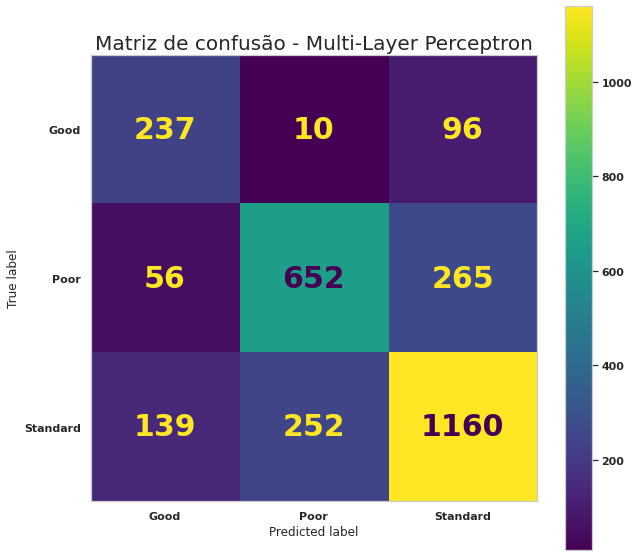

In [107]:
print(classification_report(y_test, y_pred_mlpc))
cmp1 = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_mlpc), display_labels=['Good', 'Poor', 'Standard'])
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(False)
cmp1.plot(ax=ax)
plt.rc('font', **font)
plt.title('Matriz de confusão - Multi-Layer Perceptron', fontsize = 20)
plt.show()

In [108]:
r_auc_mlp = roc_auc_score(y_test, mlpc.predict_proba(X_test), multi_class = 'ovo')
print('MLP Classifier tem AUROC = %.3f' % (r_auc_mlp))

MLP Classifier tem AUROC = 0.856


### 5º Modelo: Stacking de XGBoost com SVC

In [109]:
# #Otimização Bayesiana de hiperparâmetros
# svc = SVC(random_state=42, max_iter=200)

# svc_params = {'probability': [True, False],
#               'kernel': ['rbf', 'linear', 'poly'],
#               'degree': [2, 3, 4],
#               'C': [0.1, 1.0, 10.0],
#               'gamma': ['scale', 'auto'],
#               'tol': [1e-5],
#               'shrinking': [True, False]
#               }

# bayessearch_svc = BayesSearchCV(svc,
#                                 svc_params,
#                                 cv = 3,
#                                 scoring = 'accuracy',
#                                 refit = 'accuracy',
#                                 verbose = 1,
#                                 n_jobs = -1,
#                                 random_state=42).fit(X_train, y_train)

# y_pred_mlpc = bayessearch_svc.predict(X_test)
# bayessearch_svc.best_params_

In [110]:
estimators = [('xgbc', XGBClassifier(eval_metric = 'logloss',
                                     use_label_encoder = False,
                                     random_state = 42,
                                     colsample_bytree = 0.6,
                                     gamma = 1.0,
                                     learning_rate = 0.1,
                                     max_depth = None,
                                     min_child_weight = 0.7,
                                     n_estimators = 1500,
                                     subsample = 1.0)),
              
              ('svc', SVC(random_state=42, 
                          C = 0.1,
                          degree = 3,
                          gamma ='scale',
                          kernel = 'poly',
                          probability = False,
                          shrinking = True,
                          tol = 1e-05))]

stackingclf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=42, max_iter=400), cv=5).fit(X_train, y_train)

y_pred_stacking = stackingclf.predict(X_test)

KeyboardInterrupt: 

In [ ]:
print(classification_report(y_test, y_pred_stacking))
cmp1 = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_stacking), display_labels=['Good', 'Poor', 'Standard'])
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(False)
cmp1.plot(ax=ax)
plt.rc('font', **font)
plt.title('Matriz de confusão - Stacking XGBoost com SVC', fontsize = 20)
plt.show()

In [ ]:
r_auc_stacking = roc_auc_score(y_test, stackingclf.predict_proba(X_test), multi_class = 'ovo')
print('Stacking Classifier tem AUROC = %.3f' % (r_auc_stacking))

## Comparativos dos modelos

In [ ]:
#Extra Trees: y_pred_xt
#Random Forest: y_pred_rf
#XGBoost: y_pred_xgbc;
#Multi-Layer Perceptron: y_pred_mlpc
#Stacking Classifier: y_pred_stacking

In [ ]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, modelname, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC curve - for {modelname}', fontdict={'fontsize': 26})
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.3f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

In [ ]:
plot_multiclass_roc(dummymodel, X_test, y_test, n_classes = 3, modelname = 'Dummy Classifier', figsize = (16,10))
plot_multiclass_roc(xtclf, X_test, y_test, 3, 'Extra Trees', (16, 10))
plot_multiclass_roc(rfclf, X_test, y_test, 3, 'Random Forest', (16, 10))
plot_multiclass_roc(xgbclassifier, X_test, y_test, 3, 'XGBoost', (16, 10))
plot_multiclass_roc(mlpc, X_test, y_test, 3, 'Multi-Layer Perceptron', (16, 10))
plot_multiclass_roc(stackingclf, X_test, y_test, 3, 'Stacking', (16, 10))

#### Curvas ROC conjuntas (para a classe Standard)

In [ ]:
def plot_allmodels_roc(clf, X_test, y_test, figsize=(17, 6)):
    y_score = []

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    
    for i, it in zip(clf, range(len(clf))):
        y_score = i.predict_proba(X_test)[:, 2]
        fpr[it], tpr[it], _ = roc_curve(y_test_dummies[:, 2], y_score)
        roc_auc[it] = auc(fpr[it], tpr[it])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--', label='DummyClassifier (AUC = 0.500)')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC curve for Standard Class (OvR) - All models', fontdict={'fontsize': 26})
    
    for i, it in zip(clf, range(len(clf))):
        ax.plot(fpr[it], tpr[it], label='%s (AUC = %0.3f)' % (i.__class__.__name__, roc_auc[it]))
        
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

In [ ]:
plot_allmodels_roc([rfclf, xtclf, xgbclassifier, mlpc, stackingclf], X_test, y_test)

### Tabela comparativa de Métricas

In [ ]:
def perf_measure(y_actual, y_hat):
   
   metricas = []
   TP, FP, TN, FN = 0, 0, 0, 0
   
   TP = confusion_matrix(y_actual, y_hat)[2][2]
   FP = confusion_matrix(y_actual, y_hat)[0][2] + confusion_matrix(y_actual, y_hat)[1][2]
   TN = confusion_matrix(y_actual, y_hat)[0][0] + confusion_matrix(y_actual, y_hat)[0][1] + confusion_matrix(y_actual, y_hat)[1][0] + confusion_matrix(y_actual, y_hat)[1][1]
   FN = confusion_matrix(y_actual, y_hat)[2][0] + confusion_matrix(y_actual, y_hat)[2][1]
   
   metricas.append(TP)
   metricas.append(FP)
   metricas.append(TN)
   metricas.append(FN)
   
   return metricas

In [ ]:
comparativo_final_metricas = pd.DataFrame(columns = ['Acurácia', 'Recall', 'FN', 'F1-Score', 'AUROC'])

comparativo_final_metricas.loc['Dummy'] = [accuracy_score(y_test, y_pred_dummy).round(4),
                                           recall_score(y_test, y_pred_dummy, average='macro').round(4),
                                           perf_measure(y_test, y_pred_dummy)[3].sum(),
                                           f1_score(y_test, y_pred_dummy, average='macro').round(4),
                                           r_auc_dummy.round(4)
                                           ]

comparativo_final_metricas.loc['Extra Trees'] = [accuracy_score(y_test, y_pred_xt).round(4),
                                                 recall_score(y_test, y_pred_xt, average='macro').round(4),
                                                 perf_measure(y_test, y_pred_xt)[3].sum(),
                                                 f1_score(y_test, y_pred_xt, average='macro').round(4),
                                                 r_auc_xt.round(4)
                                                 ]

comparativo_final_metricas.loc['Random Forest'] = [accuracy_score(y_test, y_pred_rf).round(4),
                                                   recall_score(y_test, y_pred_rf, average='macro').round(4),
                                                   perf_measure(y_test, y_pred_rf)[3].sum(),
                                                   f1_score(y_test, y_pred_rf, average='macro').round(4),
                                                   r_auc_rf.round(4)
                                                   ]

comparativo_final_metricas.loc['XGBoost'] = [accuracy_score(y_test, y_pred_xgbc).round(4),
                                             recall_score(y_test, y_pred_xgbc, average='macro').round(4),
                                             perf_measure(y_test, y_pred_xgbc)[3].sum(),
                                             f1_score(y_test, y_pred_xgbc, average='macro').round(4),
                                             r_auc_xgbc.round(4)
                                             ]

comparativo_final_metricas.loc['Multi Layer Perceptron'] = [accuracy_score(y_test, y_pred_mlpc).round(4),
                                                            recall_score(y_test, y_pred_mlpc, average='macro').round(4),
                                                            perf_measure(y_test, y_pred_mlpc)[3].sum(),
                                                            f1_score(y_test, y_pred_mlpc, average='macro').round(4),
                                                            r_auc_rf.round(4)
                                                            ]

comparativo_final_metricas.loc['Stacking'] = [accuracy_score(y_test, y_pred_stacking).round(4),
                                              recall_score(y_test, y_pred_stacking, average='macro').round(4),
                                              perf_measure(y_test, y_pred_stacking)[3].sum(),
                                              f1_score(y_test, y_pred_stacking, average='macro').round(4),
                                              r_auc_stacking.round(4)
                                              ]

In [ ]:
comparativo_final_metricas = comparativo_final_metricas.sort_values(by='Acurácia', ascending=False)
comparativo_final_metricas

#### FIM